In [67]:
import numpy as np
import matplotlib.pyplot as plt

In [68]:
T = 10
dt = 0.001
N = int(T/dt + 1)
c0 = 0

In [69]:
def white_noise(T, dt, c_0, c_k):
    t = np.arange(0, T, dt)
    N = int(T/dt + 1)
    
    k = np.arange(1, int(N/2))
    f_k = k / T
    phi_k = np.random.uniform(0, 2 * np.pi, len(k))
    
    x = []
    for t_i in t:
        x_i = c0/2 + np.sum(c_k * np.sin(2 * np.pi * f_k * t_i + phi_k))
        x.append(x_i)
    return np.array(x)

In [70]:
t = np.arange(0, 10, dt)
t_i = t[50]
c_k = 1

k = np.arange(1, int(N/2))
f_k = k / T
phi_k = np.random.uniform(0, 2 * np.pi, len(k))
x_i = c0/2 + np.sum(c_k * np.sin(2 * np.pi * f_k * t_i + phi_k))

In [71]:
v = white_noise(10, 0.001, c_0=0, c_k=1)

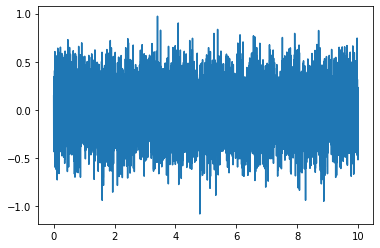

In [64]:
fig = plt.figure()
plt.plot(t, v/200)

In [2]:
# Generating white noise with randomgaussian coefficients
import numpy as np
import matplotlib.pyplot as plt
from data_fns import butter_bandpass_filter

In [44]:
def bp_weights(M, N, lowcut, highcut, fs):
    J = np.random.randn(M, N)
    J = butter_bandpass_filter(J, lowcut, highcut, fs)
    return J.T

def bp_weights_gaus(M, N, lowcut, highcut, fs):
    W = np.zeros((M, N))

    t_points = np.arange(N) / fs
    wk = 2 * np.pi * np.arange(lowcut, highcut + 1)
    
    c = 1
    Sk = 1
    for i in range(M):
        Ak = np.random.normal(size=(len(wk), 2))
        for j, t in enumerate(t_points):
            W[i, j] = c / np.sqrt(np.pi) * np.sum(Sk * (Ak[:, 0] * np.cos(wk * t) + Ak[:, 1] * np.sin(wk * t)))
    return W.T

In [71]:
M = 20
N = 140
fs = 2000
lowcut, highcut = 30, 100

Wgaus = bp_weights_gaus(M, N, lowcut, highcut, fs)
W = bp_weights(M, N, lowcut, highcut, fs)

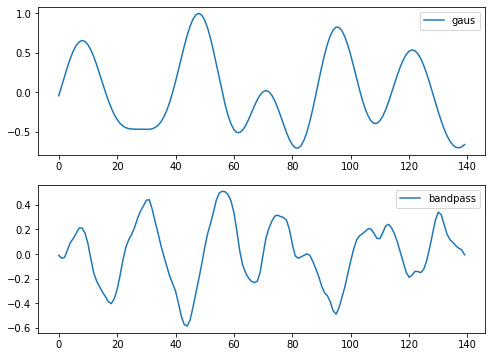

In [86]:
i = np.random.randint(M)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(211)
plt.plot(Wgaus.T[i] / np.max(Wgaus.T[i]), label='gaus')
plt.legend()
ax = fig.add_subplot(212)
plt.plot(W.T[i], label='bandpass')
plt.legend()